In [1]:
print('STOP! Do you really want to run this locally in Jupyter? Probably not!')

STOP! Do you really want to run this locally in Jupyter? Probably not!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
import astropy.constants as c

import random
import os
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import time
import sys
import gc

In [3]:
# define demarcation lines

def kauf_line():
    x=np.linspace(-2.5, 0, 100)
    y = (0.61/(x - 0.05) + 1.3)
    return x, y

def kewl_line():
    x=np.linspace(-2.5, 0.4, 100)
    y = (0.61/(x - 0.47) + 1.19)
    return x, y

def law_line():
    x=np.linspace(-0.24, 0.5)
    y = 0.95*x+0.56
    return x, y

# use these to generate points to cover a larger grid space
def kauf_line_alt(x):
    #x=np.linspace(-2.5, -0.75, 100)
    y = (0.61/(x - (0.05-0.75)) + (1.3-0.75))
    return y
def kewl_line_alt(x):
    #x=np.linspace(-2.5, 0.65, 100)
    y = (0.61/(x - (0.47+0.75)) + (1.19+0.75))
    return y

In [4]:
def get_data_file_path(filename):
    # Get the directory where this script is located
    script_dir = os.path.dirname(os.path.realpath(filename))

    # Construct the path to the data file relative to the script location
    data_file_path = os.path.join(script_dir, 'data', filename)

    return data_file_path

In [5]:
# read in BPT data
eboss = pd.read_csv(get_data_file_path('eboss_bpt.csv'))
dfsf = eboss.loc[eboss['gal'] == 'sf']
dfagn = eboss.loc[(eboss['gal'] == 'agn') | (eboss['gal'] == 'lmagn')]
dfr = eboss.loc[(eboss['gal'] != 'sf') | (eboss['gal'] != 'agn') | (eboss['gal'] != 'lmagn')]

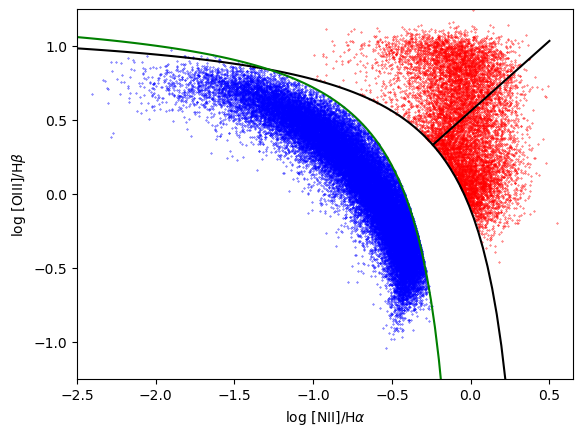

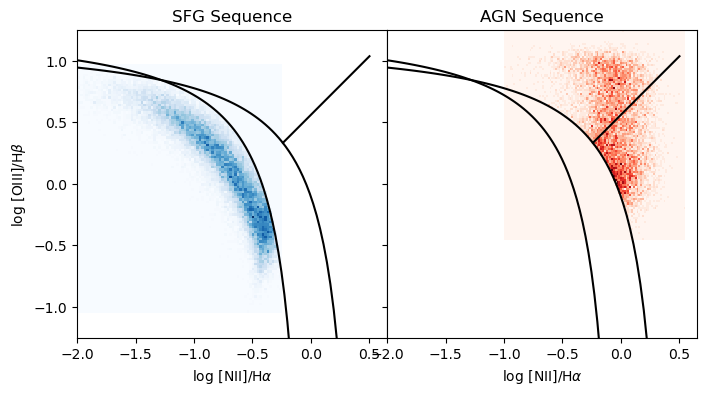

In [6]:
#plt.scatter(dfr['x'], dfr['y'], c='coral', s=1)
plt.scatter(dfsf['x'], dfsf['y'], c='b', s=0.1)
plt.scatter(dfagn['x'], dfagn['y'], c='r', s=0.1)
plt.plot(kewl_line()[0], kewl_line()[1], c='k')
plt.plot(kauf_line()[0], kauf_line()[1], c='g')
plt.plot(law_line()[0], law_line()[1], c='k')
plt.xlim(-2.5, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'log [NII]/H$\alpha$')
plt.ylabel(r'log [OIII]/H$\beta$')
plt.show()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))

ax[0].hist2d(dfsf['x'], dfsf['y'], bins=100, cmap='Blues')
ax[0].plot(kewl_line()[0], kewl_line()[1], c='k')
ax[0].plot(kauf_line()[0], kauf_line()[1], c='k')
ax[0].plot(law_line()[0], law_line()[1], c='k')
ax[0].set_xlabel(r'log [NII]/H$\alpha$')
ax[0].set_ylabel(r'log [OIII]/H$\beta$')
ax[0].set_title('SFG Sequence')

ax[1].hist2d(dfagn['x'], dfagn['y'], bins=100, cmap='Reds')
ax[1].plot(kewl_line()[0], kewl_line()[1], c='k')
ax[1].plot(kauf_line()[0], kauf_line()[1], c='k')
ax[1].plot(law_line()[0], law_line()[1], c='k')
ax[1].set_xlim(-2, 0.65)
ax[1].set_ylim(-1.25, 1.25)
ax[1].set_xlabel(r'log [NII]/H$\alpha$')
ax[1].set_title('AGN Sequence')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [7]:
# these are points in extreme grid space to add
sfg_add_x = np.linspace(-2.5, -1, 10)
sfg_add_y = kauf_line_alt(sfg_add_x)

agn_add_x = np.linspace(-0.5, 0.85, 10)
agn_add_y = kewl_line_alt(agn_add_x)

In [8]:
# Example logic for computing total_points
def compute_total_points(hist, min_points=1, max_points=50):
    """
    Compute the total points required to satisfy the condition that
    every bin has at least `min_points` and the densest bin has `max_points`.

    hist: 2D histogram array
    min_points: minimum points per bin
    max_points: maximum points for the densest bin
    """
    # Find non-empty bins
    non_empty_bins = hist > 0
    num_non_empty_bins = np.sum(non_empty_bins)

    if num_non_empty_bins == 0:
        return 0  # no points required if there are no non-empty bins

    # Find min and max densities of non-empty bins
    min_density = hist[non_empty_bins].min()
    max_density = hist[non_empty_bins].max()

    # Scale densities from min_points to max_points
    scaled_density = np.zeros_like(hist, dtype=float)
    if max_density > min_density:
        scaled_density[non_empty_bins] = (
            (hist[non_empty_bins] - min_density) / (max_density - min_density) * (max_points - min_points) + min_points
        )
    else:
        # If all bins have the same density, assign max_points to all
        scaled_density[non_empty_bins] = max_points

    # Compute total points
    total_points = int(np.ceil(np.sum(scaled_density[non_empty_bins])))
    return total_points

In [9]:
# generate points with scatter based on a 2D histogram
def gen_points_2d(x, y, bins, total_points, scatter_range=0.01):
    """
    Function to generate points (with scatter) based on 2d histogram.
    x: x-data
    y: y-data
    bins: number of bins in the 2d histogram
    total_points: number of generated points
    scatter_range: how much scatter we want (in dex)
    """
    # compute 2d histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # find non-empty bins
    non_empty_bins = hist > 0
    bin_indices = np.argwhere(non_empty_bins)

    # normalize densities to range from 1 to N for non-empty bins
    # least populated bins will have 1 generated data point
    # most populated bin will have N generated data points
    N = 50
    scaled_density = np.zeros_like(hist, dtype=float)
    if non_empty_bins.any():
        min_density = hist[non_empty_bins].min()
        max_density = hist[non_empty_bins].max()
        if max_density > min_density:  # avoid divide by zero
            scaled_density[non_empty_bins] = (
                (hist[non_empty_bins] - min_density) / (max_density - min_density) * (N - 1) + 1
            )

    # scale the total number of points to match `total_points`
    density_factor = total_points / np.sum(scaled_density[non_empty_bins])
    scaled_density[non_empty_bins] *= density_factor

    # generate points based on density
    generated_x = []
    generated_y = []
    for bin_idx in bin_indices:
        i, j = bin_idx
        count = int(np.floor(scaled_density[i, j]))
        if count > 0:  # only generate points for non-empty bins!!!
            x_min, x_max = xedges[i], xedges[i + 1]
            y_min, y_max = yedges[j], yedges[j + 1]
            gen_x = np.random.uniform(x_min, x_max, count)
            gen_y = np.random.uniform(y_min, y_max, count)

            # add some scatter
            gen_x += np.random.uniform(-scatter_range, scatter_range, count)
            gen_y += np.random.uniform(-scatter_range, scatter_range, count)

            generated_x.extend(gen_x)
            generated_y.extend(gen_y)

    # double check the total number of points matches exactly
    generated_x = np.array(generated_x)
    generated_y = np.array(generated_y)
    if len(generated_x) > total_points:
        # Trim excess points
        indices = np.random.choice(len(generated_x), total_points, replace=False)
        generated_x = generated_x[indices]
        generated_y = generated_y[indices]
    elif len(generated_x) < total_points:
        # pad with additional random points in non-empty bins
        missing_points = total_points - len(generated_x)
        pad_x = []
        pad_y = []
        while len(pad_x) < missing_points:
            i, j = bin_indices[np.random.choice(len(bin_indices))]
            x_min, x_max = xedges[i], xedges[i + 1]
            y_min, y_max = yedges[j], yedges[j + 1]
            gen_x = np.random.uniform(x_min, x_max, 1)
            gen_y = np.random.uniform(y_min, y_max, 1)
            gen_x += np.random.uniform(-scatter_range, scatter_range, 1)
            gen_y += np.random.uniform(-scatter_range, scatter_range, 1)
            pad_x.extend(gen_x)
            pad_y.extend(gen_y)
        generated_x = np.concatenate([generated_x, pad_x[:missing_points]])
        generated_y = np.concatenate([generated_y, pad_y[:missing_points]])

    return generated_x, generated_y

In [10]:
bins = 100
# Compute histogram
hist, xedges, yedges = np.histogram2d(dfsf['x'], dfsf['y'], bins=bins)

# Compute number of points so each bin has at least 1 point and the densest bin has ~50 points
total_points = compute_total_points(hist)
N = total_points + len(sfg_add_x)

In [12]:
    # sfg data
    scatter_range = 0.01
    sfx_a, sfy_a = gen_points_2d(dfsf['x'], dfsf['y'], bins, total_points=total_points, scatter_range=scatter_range)
    # reshuffle indices
    ind_sf = np.arange(len(sfx_a))
    np.random.shuffle(ind_sf)
    sfx_a = sfx_a[ind_sf]
    sfy_a = sfy_a[ind_sf]
    # add outside points
    sfx = np.append(sfx_a, sfg_add_x)
    sfy = np.append(sfy_a, sfg_add_y)

    # agn data
    agnx_a, agny_a = gen_points_2d(dfagn['x'], dfagn['y'], bins, total_points=total_points, scatter_range=scatter_range)
    # reshuffle indices
    ind_agn = np.arange(len(agnx_a))
    np.random.shuffle(ind_agn)
    agnx_a = agnx_a[ind_agn]
    agny_a = agny_a[ind_agn]
    # add outside points
    agnx = np.append(agnx_a, agn_add_x)
    agny = np.append(agny_a, agn_add_y)

    # validate matching lengths
    print(f"Length of SF Points: {len(sfx)}, Length of AGN points: {len(agnx)}")
    print('Data have been generated')

Length of SF Points: 24513, Length of AGN points: 24513
Data have been generated


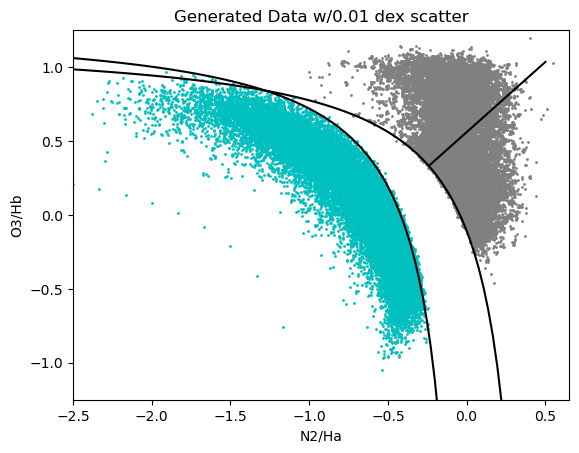

In [13]:
#plt.figure(figsize=(8, 6))
plt.scatter(sfx, sfy, color='c', s=1)
plt.scatter(agnx, agny, color='gray', s=1)
#plt.scatter(sfg_add_x, sfg_add_y, c='k')
#plt.scatter(agn_add_x, agn_add_y, c='r')
#plt.hist2d(dfsf['x'], dfsf['y'], bins=bins, cmap='Blues', alpha=0.5)
plt.plot(kewl_line()[0], kewl_line()[1], c='k')
plt.plot(kauf_line()[0], kauf_line()[1], c='k')
plt.plot(law_line()[0], law_line()[1], c='k')
plt.xlim(-2.5, 0.65)
plt.ylim(-1.25, 1.25)
#plt.xlim(-2.75, 0.85)
#plt.ylim(-1.5, 2)
plt.xlabel('N2/Ha')
plt.ylabel('O3/Hb')
plt.title('Generated Data w/0.01 dex scatter')
#plt.legend()
plt.show()

In [14]:
# do the calculations
#N = len(sfx)
balmer_dec = 2.86

# H-alpha caontribution is 1 (doesn't matter bc they are all ratios)
sfha = np.linspace(1, 1, N)
# balmer decrement
sfhb = sfha/balmer_dec
# SFG N2 contribution based of the SFG points and SFG H-alpha
sfn2 = sfha*(10**sfx)
# same idea as sfn2
sfo3 = sfhb*(10**sfy)

# fractional AGN contribution
f = np.linspace(0.01, 0.99, 981)

# calculating the AGN O3 contribution for a given f-value
# f = agno3/(sfo3+agno3) ----> ao3 = -f*sfo3/(f-1)
agno3 = []
for index, value in enumerate(sfo3):
        agno3.append((-f[:]*value)/(f[:]-1))

# calculating agn hb, ha, & n2 based on various lines and the agn x & y components
agnhb = []
for index, value in enumerate(agno3):
    agnhb.append(value/(10**agny[index]))

agnha = []
for i in agnhb:
    agnha.append(i*balmer_dec)

agnn2 = []
for index, value in enumerate(agnha):
    agnn2.append(value*(10**agnx[index]))

# calculating the total n2, ha, o3, hb contribution for a given f value 
# n2_tot = agnn2+sfgn2, etc.
n2 = []
for index, value in enumerate(agnn2):
    n2.append(value+sfn2[index])

ha = []
for index, value in enumerate(agnha):
    ha.append(value+sfha[index])

o3 = []
for index, value in enumerate(agno3):
    o3.append(value+sfo3[index])

hb = []
for index, value in enumerate(agnhb):
    hb.append(value+sfhb[index])

# translating n2, ha, o3, hb into log x & y space
x = []
for index, value in enumerate(n2):
    x.append(np.log10(value/ha[index]))

y = []
for index, value in enumerate(o3):
    y.append(np.log10(value/hb[index]))


# making array with x/y and f values
xs = []
ys = []
for i in range(N):
    xs.append((np.array( x[i][:]), f))                          
    ys.append((np.array( y[i][:]), f))

#  putting x/y values in df where the index number is the fractional AGN contribution
dfx = pd.DataFrame({i: xs[i][0] for i in range(N)}, index=f)
dfy = pd.DataFrame({i: ys[i][0] for i in range(N)}, index=f)

BPT with individual tracks created.


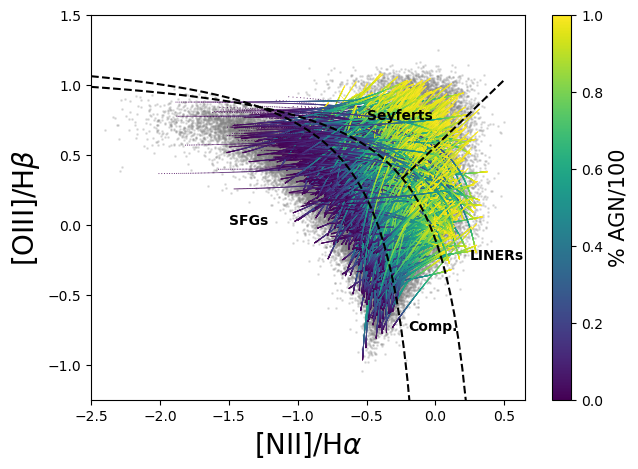

In [15]:
plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=1, alpha=0.2,)
for i in range(1000):
    plt.scatter(dfx[i], dfy[i], c=dfx.index.tolist(), edgecolor='none',  s=0.5)
plt.colorbar().set_label(label=r'% AGN/100', size=15)
plt.clim(0, 1.0)
plt.plot(kewl_line()[0], kewl_line()[1], c='k', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='k', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='k', linestyle='dashed')
plt.xlim(-2.5, 0.65)
plt.ylim(-1.25, 1.5)
plt.xlabel(r'[NII]/H$\alpha$', fontsize=20)
plt.ylabel(r'[OIII]/H$\beta$', fontsize=20)
plt.text(-1.5, 0.0, 'SFGs', c='k', fontweight='bold')
plt.text(-0.2, -0.75, 'Comp.', c='k', fontweight='bold')
plt.text(0.25, -0.25, 'LINERs', c='k', fontweight='bold')
plt.text(-0.5, 0.75, 'Seyferts', c='k', fontweight='bold')
#plt.savefig('plots/tracks_individual.pdf')
print('BPT with individual tracks created.')
plt.show()
#"""

BPT with all tracks created


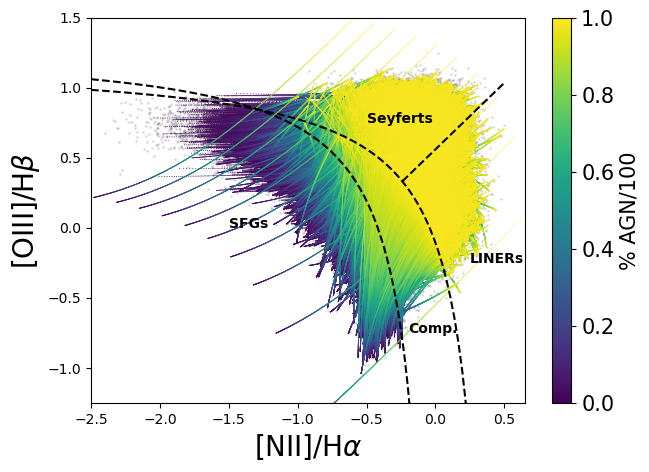

In [16]:
# Optimized visualization code
plt.figure(figsize=(7, 5))
# Plot the background scatter for 'eboss'
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=1, alpha=0.2)
# Prepare all points from dfx and dfy for a single scatter plot
all_x = np.concatenate(dfx.values)  # Flatten dfx
all_y = np.concatenate(dfy.values)  # Flatten dfy
colors = np.repeat(dfx.index, dfx.shape[1])  # Repeat indices for coloring
# Single scatter plot for tracks
plt.scatter(all_x, all_y, c=colors, edgecolor='none', s=0.5)
# Add colorbar
cbar = plt.colorbar()
cbar.set_label(label=r'% AGN/100', size=15)
cbar.ax.tick_params(labelsize=15)
plt.clim(0, 1.0)
# Plot pre-computed lines
plt.plot(kewl_line()[0], kewl_line()[1], c='k', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='k', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='k', linestyle='dashed')
# Set axis limits and labels
plt.xlim(-2.5, 0.65)
plt.ylim(-1.25, 1.5)
plt.xlabel(r'[NII]/H$\alpha$', fontsize=20)
plt.ylabel(r'[OIII]/H$\beta$', fontsize=20)
# Annotate regions
plt.text(-1.5, 0.0, 'SFGs', c='k', fontweight='bold')
plt.text(-0.2, -0.75, 'Comp.', c='k', fontweight='bold')
plt.text(0.25, -0.25, 'LINERs', c='k', fontweight='bold')
plt.text(-0.5, 0.75, 'Seyferts', c='k', fontweight='bold')
#plt.savefig('plots/tracks_clean.pdf')
print('BPT with all tracks created')
plt.show()

In [17]:
def f_agn_nearest(dfx, dfy, x, y, num):
    distances = np.sqrt((dfx - x)**2 + (dfy - y)**2)
    # get nearest N points
    min_vals = distances.stack().nsmallest(num)
    min_inds = min_vals.index
    result = [index[0] for index in min_inds]
    return result

def f_agn_radial(dfx, dfy, x, y, radius):
    distances = np.sqrt((dfx - x)**2 + (dfy - y)**2)
    mask = distances < radius
    result = distances.index[mask.any(axis=1)].tolist()
    if not result:
        return np.nan
    else:
        return result
        
# Combined method: Use radius for points in model space, use nearest N for points outside
def f_agn_combined(dfx, dfy, x, y, radius, num=20):
    distances = np.sqrt((dfx - x)**2 + (dfy - y)**2)
    # Select points within the radius
    mask = distances < radius
    result = distances.index[mask.any(axis=1)].tolist()
    # If no points are within the radius, return the nearest N points
    if not result:
        min_vals = distances.stack().nsmallest(num)
        min_inds = min_vals.index
        result = [index[0] for index in min_inds]
    return result

In [18]:
# Generate x and y values
x_values = np.arange(-2.25, 0.75, 0.5)
y_values = np.arange(-1.25, 1.35, 0.5)

# Create a meshgrid
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# Flatten the meshgrid to get x and y values
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()

# Create the DataFrame
dfgrid = pd.DataFrame({'x': x_flat, 'y': y_flat})


# takes ~80 minutes for 10,000 tracks & 3120 galaxies
# Define a helper function for processing
def calculate_fraction(radius):
    start_time = time.time()
    result = dfgrid.apply(lambda row: f_agn_combined(dfx, dfy, row['x'], row['y'], radius=radius), axis=1)
    end_time = time.time()
    tot_time = end_time - start_time
    print(f'For Combined Method (r={radius}) {len(dfgrid)} galaxies & {len(dfx)} lines it takes {tot_time} seconds')
    return result

In [19]:
# Define the radii
#radii = [0.025, 0.05, 0.075, 0.1]
print('Starting lookup table creation. ')

Starting lookup table creation. 


Progress: 97.22% completed
For Radial Method (r=0.025) 36 galaxies & 24513 tracks it takes 18.34323000907898 seconds


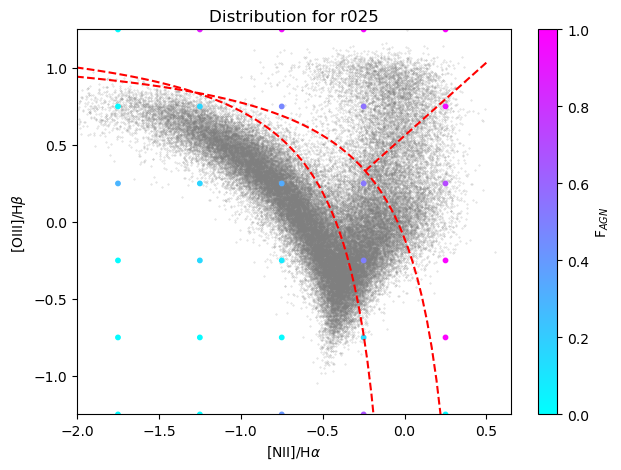

Trash has been taken out for r025


In [29]:
start_time = time.time()
total_steps = len(dfgrid)
frac_agn_r025 = dfgrid.apply(
    lambda row: (print(f"Progress: {row.name / total_steps * 100:.2f}% completed", end="\r"),
                 f_agn_combined(dfx, dfy, row['x'], row['y'], radius=0.025))[1], axis=1)
end_time = time.time()
tot_time = end_time - start_time
print('\nFor Radial Method (r=0.025)', len(dfgrid), 'galaxies &', len(dfx.columns), 'tracks it takes', tot_time, 'seconds')

dfgrid_r025 = dfgrid.copy()
dfgrid_r025['frac_agn'] = frac_agn_r025
dfgrid_r025['f_mean'] = dfgrid_r025['frac_agn'].apply(np.nanmean)
dfgrid_r025['f_median'] = dfgrid_r025['frac_agn'].apply(np.median)
dfgrid_r025['f_std'] = dfgrid_r025['frac_agn'].apply(np.std)
dfgrid_r025['f_var'] = dfgrid_r025['frac_agn'].apply(np.var)

plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
plt.scatter(dfgrid_r025['x'], dfgrid_r025['y'], c=dfgrid_r025['f_mean'], cmap='cool', marker='o', s=10)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.title(f'Distribution for r025')
plt.savefig('plots/grid_sampling_r025.pdf')
plt.show()   

dfgrid_r025.to_csv('data/table_r025.csv', index=None)

del dfgrid_r025, frac_agn_r025
gc.collect()
print('Trash has been taken out for r025')

Progress: 97.22% completed
For Radial Method (r=0.05) 36 galaxies & 24513 tracks it takes 17.238687992095947 seconds


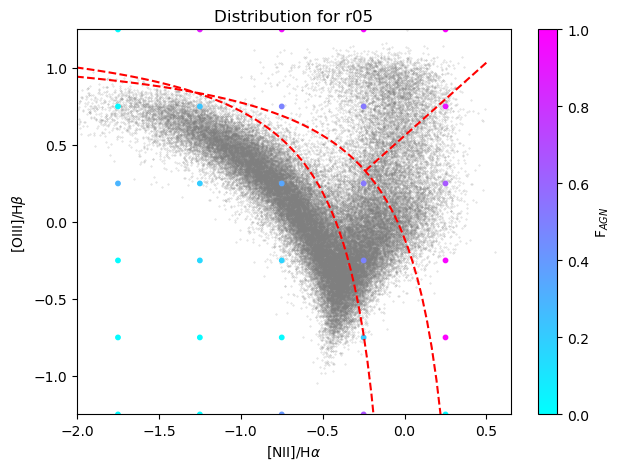

Trash has been taken out for r05


In [21]:
start_time = time.time()
total_steps = len(dfgrid)
frac_agn_r05 = dfgrid.apply(
    lambda row: (print(f"Progress: {row.name / total_steps * 100:.2f}% completed", end="\r"),
                 f_agn_combined(dfx, dfy, row['x'], row['y'], radius=0.05))[1], axis=1)
end_time = time.time()
tot_time = end_time - start_time
print('\nFor Radial Method (r=0.05)', len(dfgrid), 'galaxies &', len(dfx.columns), 'tracks it takes', tot_time, 'seconds')

dfgrid_r05 = dfgrid.copy()
dfgrid_r05['frac_agn'] = frac_agn_r05
dfgrid_r05['f_mean'] = dfgrid_r05['frac_agn'].apply(np.nanmean)
dfgrid_r05['f_median'] = dfgrid_r05['frac_agn'].apply(np.median)
dfgrid_r05['f_std'] = dfgrid_r05['frac_agn'].apply(np.std)
dfgrid_r05['f_var'] = dfgrid_r05['frac_agn'].apply(np.var)

plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
plt.scatter(dfgrid_r05['x'], dfgrid_r05['y'], c=dfgrid_r05['f_mean'], cmap='cool', marker='o', s=10)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.title(f'Distribution for r05')
plt.savefig('plots/grid_sampling_r05.pdf')
plt.show()   

dfgrid_r05.to_csv('data/table_r05.csv', index=None)

del dfgrid_r05, frac_agn_r05
gc.collect()
print('Trash has been taken out for r05')

Progress: 97.22% completed
For Radial Method (r=0.075) 36 galaxies & 24513 tracks it takes 16.94613814353943 seconds


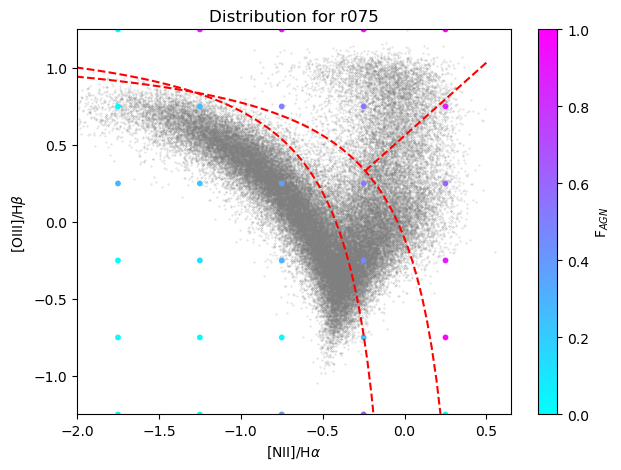

Trash has been taken out for r075


In [22]:
start_time = time.time()
total_steps = len(dfgrid)
frac_agn_r075 = dfgrid.apply(
    lambda row: (print(f"Progress: {row.name / total_steps * 100:.2f}% completed", end="\r"),
                 f_agn_combined(dfx, dfy, row['x'], row['y'], radius=0.075))[1], axis=1)
end_time = time.time()
tot_time = end_time - start_time
print('\nFor Radial Method (r=0.075)', len(dfgrid), 'galaxies &', len(dfx.columns), 'tracks it takes', tot_time, 'seconds')

dfgrid_r075 = dfgrid.copy()
dfgrid_r075['frac_agn'] = frac_agn_r075
dfgrid_r075['f_mean'] = dfgrid_r075['frac_agn'].apply(np.nanmean)
dfgrid_r075['f_median'] = dfgrid_r075['frac_agn'].apply(np.median)
dfgrid_r075['f_std'] = dfgrid_r075['frac_agn'].apply(np.std)
dfgrid_r075['f_var'] = dfgrid_r075['frac_agn'].apply(np.var)

plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
plt.scatter(dfgrid_r075['x'], dfgrid_r075['y'], c=dfgrid_r075['f_mean'], cmap='cool', marker='o', s=10)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.title(f'Distribution for r075')
plt.savefig('plots/grid_sampling_r075.pdf')
plt.show()   

dfgrid_r075.to_csv('data/table_r075.csv', index=None)

del dfgrid_r075, frac_agn_r075
gc.collect()
print('Trash has been taken out for r075')

Progress: 97.22% completed
For Radial Method (r=0.1) 36 galaxies & 24513 tracks it takes 16.771819829940796 seconds
Lookup tables created.


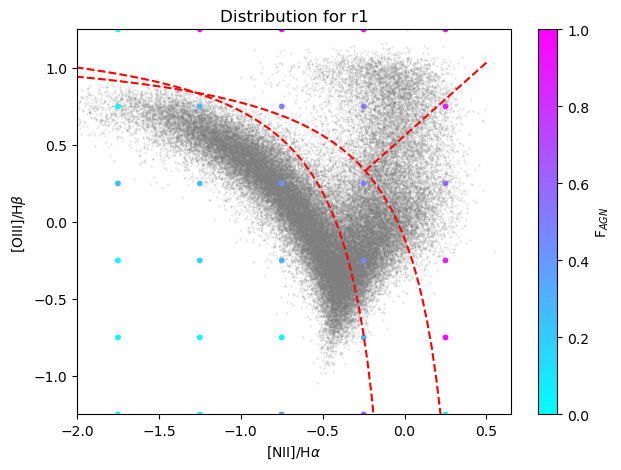

Trash has been taken out for r1


In [23]:
start_time = time.time()
total_steps = len(dfgrid)
frac_agn_r1 = dfgrid.apply(
    lambda row: (print(f"Progress: {row.name / total_steps * 100:.2f}% completed", end="\r"),
                 f_agn_combined(dfx, dfy, row['x'], row['y'], radius=0.1))[1], axis=1)
end_time = time.time()
tot_time = end_time - start_time
print('\nFor Radial Method (r=0.1)', len(dfgrid), 'galaxies &', len(dfx.columns), 'tracks it takes', tot_time, 'seconds')

print('Lookup tables created.')

dfgrid_r1 = dfgrid.copy()
dfgrid_r1['frac_agn'] = frac_agn_r1
dfgrid_r1['f_mean'] = dfgrid_r1['frac_agn'].apply(np.nanmean)
dfgrid_r1['f_median'] = dfgrid_r1['frac_agn'].apply(np.median)
dfgrid_r1['f_std'] = dfgrid_r1['frac_agn'].apply(np.std)
dfgrid_r1['f_var'] = dfgrid_r1['frac_agn'].apply(np.var)

plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
plt.scatter(dfgrid_r1['x'], dfgrid_r1['y'], c=dfgrid_r1['f_mean'], cmap='cool', marker='o', s=10)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.title(f'Distribution for r1')
plt.savefig('plots/grid_sampling_r1.pdf')
plt.show()   

dfgrid_r1.to_csv('data/table_r1.csv', index=None)

del dfgrid_r1, frac_agn_r1
gc.collect()
print('Trash has been taken out for r1')

In [28]:
# parallelization, but something is wrong
"""
import concurrent.futures

def process_radius(radius, dfgrid):
    start_time = time.time()
    total_steps = len(dfgrid)
    print(f"Starting computation for radius={radius}\n")

    # Calculate `frac_agn`
    frac_agn = dfgrid.apply(
        lambda row: f_agn_combined(dfx, dfy, row['x'], row['y'], radius=radius)[1], axis=1
    )

    end_time = time.time()
    tot_time = end_time - start_time
    print(f'\nFor Radial Method (r={radius}) {len(dfgrid)} galaxies & {len(dfx.columns)} tracks it took {tot_time} seconds')

    # Prepare DataFrame
    dfgrid_result = dfgrid.copy()
    dfgrid_result['frac_agn'] = frac_agn
    dfgrid_result['f_mean'] = dfgrid_result['frac_agn'].apply(np.nanmean)
    dfgrid_result['f_median'] = dfgrid_result['frac_agn'].apply(np.median)
    dfgrid_result['f_std'] = dfgrid_result['frac_agn'].apply(np.std)
    dfgrid_result['f_var'] = dfgrid_result['frac_agn'].apply(np.var)

    # Plotting
    plt.figure(figsize=(7, 5))
    plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
    plt.scatter(dfgrid_result['x'], dfgrid_result['y'], c=dfgrid_result['f_mean'], cmap='cool', marker='o', s=10)
    plt.colorbar(label=r'F$_{AGN}$')
    plt.clim(0, 1)
    plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
    plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
    plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
    plt.xlim(-2, 0.65)
    plt.ylim(-1.25, 1.25)
    plt.xlabel(r'[NII]/H$\alpha$')
    plt.ylabel(r'[OIII]/H$\beta$')
    plt.title(f'Distribution for r={radius}')
    plt.savefig(f'plots/grid_sampling_r_{radius:.3f}.pdf')
    plt.close()

    # Save to CSV
    output_file = f'data/table_r_{radius:.3f}.csv'
    dfgrid_result.to_csv(output_file, index=None)
    print(f"Data for radius={radius} saved to {output_file}")

    # Clean up
    del dfgrid_result, frac_agn
    gc.collect()
    print(f'Trash has been taken out for r={radius}')

# List of radii
radii = [0.025, 0.05, 0.075, 0.1]

# Parallel execution
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(process_radius, radius, dfgrid)
        for radius in radii
    ]
    for future in concurrent.futures.as_completed(futures):
        try:
            future.result()  # Ensure any exceptions are raised
        except Exception as e:
            print(f"An error occurred: {e}")
"""

Starting computation for radius=0.025
Starting computation for radius=0.05
Starting computation for radius=0.1
Starting computation for radius=0.075





For Radial Method (r=0.1) 36 galaxies & 24513 tracks it took 37.122238874435425 seconds

For Radial Method (r=0.075) 36 galaxies & 24513 tracks it took 37.79465293884277 seconds

For Radial Method (r=0.05) 36 galaxies & 24513 tracks it took 38.45094037055969 seconds
Data for radius=0.1 saved to data/table_r_0.100.csv
Trash has been taken out for r=0.1
Data for radius=0.075 saved to data/table_r_0.075.csv
Trash has been taken out for r=0.075

For Radial Method (r=0.025) 36 galaxies & 24513 tracks it took 39.14609217643738 seconds
Data for radius=0.05 saved to data/table_r_0.050.csv
Trash has been taken out for r=0.05
Data for radius=0.025 saved to data/table_r_0.025.csv
Trash has been taken out for r=0.025


In [24]:
"""
# List of frac_agn series and corresponding names for DataFrames                                                                                                                             
frac_agn_series = [
    ('r025', frac_agn_r025),
    ('r05', frac_agn_r05),
    ('r075', frac_agn_r075),
    ('r1', frac_agn_r1),
    #('n5', frac_agn_n5),                                                                                                                                                                    
    #('n10', frac_agn_n10),                                                                                                                                                                  
    #('n15', frac_agn_n15),                                                                                                                                                                  
    #('n20', frac_agn_n20)                                                                                                                                                                   
]

# Dictionary to store the new DataFrames                                                                                                                                                     
dfgrid_dict = {}


# Loop through each series                                                                                                                                                                   
for name, frac_agn in frac_agn_series:
    # Create a copy of the original DataFrame to avoid overwriting                                                                                                                           
    dfgrid_new = dfgrid.copy()

    # Assign the current series to the new DataFrame                                                                                                                                         
    dfgrid_new['frac_agn'] = frac_agn

    # Calculate statistical properties                                                                                                                                                       
    dfgrid_new['f_mean'] = dfgrid_new['frac_agn'].apply(np.nanmean)
    dfgrid_new['f_median'] = dfgrid_new['frac_agn'].apply(np.median)
    dfgrid_new['f_std'] = dfgrid_new['frac_agn'].apply(np.std)
    dfgrid_new['f_var'] = dfgrid_new['frac_agn'].apply(np.var)

    # Store the new DataFrame in the dictionary                                                                                                                                              
    dfgrid_dict[f'dfgrid_{name}'] = dfgrid_new

        # Plot                                                                                                                                                                                   
    plt.figure(figsize=(7, 5))
    plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
    plt.scatter(dfgrid_new['x'], dfgrid_new['y'], c=dfgrid_new['f_mean'], cmap='cool', marker='o', s=10)
    plt.colorbar(label=r'F$_{AGN}$')
    plt.clim(0, 1)
    plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
    plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
    plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
    plt.xlim(-2, 0.65)
    plt.ylim(-1.25, 1.25)
    plt.xlabel(r'[NII]/H$\alpha$')
    plt.ylabel(r'[OIII]/H$\beta$')
    plt.title(f'Distribution for {name}')
    #plt.savefig('plots/grid_sampling_'+str(name)+'.pdf')
    plt.show()              
"""

"\n# List of frac_agn series and corresponding names for DataFrames                                                                                                                             \nfrac_agn_series = [\n    ('r025', frac_agn_r025),\n    ('r05', frac_agn_r05),\n    ('r075', frac_agn_r075),\n    ('r1', frac_agn_r1),\n    #('n5', frac_agn_n5),                                                                                                                                                                    \n    #('n10', frac_agn_n10),                                                                                                                                                                  \n    #('n15', frac_agn_n15),                                                                                                                                                                  \n    #('n20', frac_agn_n20)                                                                        

In [25]:
#print('grid sampling plots created')


# save the lookup tables                                                                                                                                                                     
#dfgrid_dict['dfgrid_r025'].to_csv('data/table_r025.csv', index=None)
#dfgrid_dict['dfgrid_r05'].to_csv('data/table_r05.csv', index=None)
#dfgrid_dict['dfgrid_r075'].to_csv('data/table_r075.csv', index=None)
#dfgrid_dict['dfgrid_r1'].to_csv('data/table_r1.csv', index=None)

print('Lookup tables saved! Good job everyone!')



Lookup tables saved! Good job everyone!
